WATERSHED ALGORITHM


In [ ]:
import numpy as np
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

In [ ]:
def find_markers(image):
    # Calculate distance to nearest background pixel
    distance = ndi.distance_transform_edt(image)
    # Find peaks in distance map
    local_maxi = np.array(ndi.label(distance == ndi.maximum_filter(distance, footprint=np.ones((3, 3))))[0])
    # Set markers at peaks
    markers = ndi.label(local_maxi)[0]
    return markers

In [ ]:
def watershed_segmentation(image):
    # Convert to grayscale
    if len(image.shape) == 3:
        image = np.mean(image, axis=2).astype(np.uint8)
    # Convert to binary image
    thresh = np.mean(image) + 1 * np.std(image)
    binary = image > thresh
    # Find markers
    markers = find_markers(binary)
    # Perform watershed
    labels = ndi.watershed_ift(image, markers=markers)
    return labels

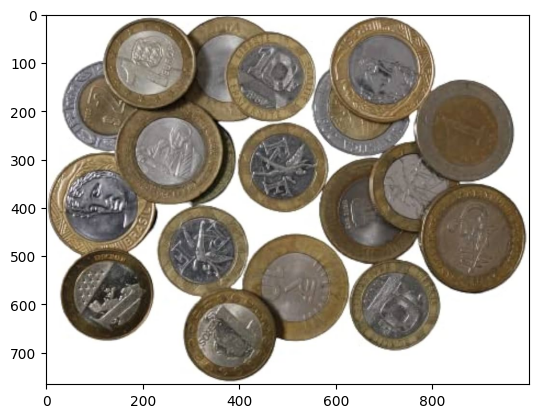

In [ ]:
# Load the image
image = plt.imread('image.jpg')
plt.imshow(image)

In [ ]:
# Perform watershed segmentation
labels = watershed_segmentation(image)

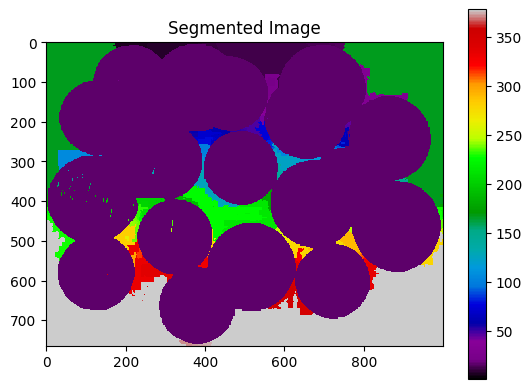

In [ ]:
# Plot segmented image
plt.imshow(labels, cmap='nipy_spectral', interpolation='nearest')
plt.colorbar()
plt.title('Segmented Image')
plt.show()

Graph Cut Algorithm for Image Segmentation

In [12]:
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from sklearn import mixture
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
import os
import timeit

In [13]:
!pip install --upgrade gdown
!gdown 1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
!unzip "/content/Part2_GraphCut.zip"

Downloading...
From: https://drive.google.com/uc?id=1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
To: /content/Part2_GraphCut.zip
100% 264k/264k [00:00<00:00, 48.9MB/s]
Archive:  /content/Part2_GraphCut.zip
replace Part2_GraphCut/dog.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/Part2_GraphCut/._dog.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Part2_GraphCut/messi.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/Part2_GraphCut/._messi.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Part2_GraphCut/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/Part2_GraphCut/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Part2_GraphCut/plane.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/Part2_GraphCut/._plane.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Part2_GraphCut/bird.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/Part2_GraphCut/._bird.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Part2_Gr

In [14]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

# Get a normalized version of the given histograms (divide by sum)
def normalize_histograms(histograms):
  return np.float32([h / h.sum() for h in histograms])

In [29]:
def mask_for_fg(img, img_mask):
  fg_image = np.zeros_like(img)
  fg_image[img_mask] = img[img_mask]
  return fg_image

def mask_for_bg(img, img_mask):
  bg_image = np.zeros_like(img)
  bg_image[~img_mask] = img[~img_mask]
  return bg_image


def visualize_likelihood_map(gmm_bg, gmm_fg, img):
  original_image = copy.deepcopy(img)
  print( " Orginal Image Shape : ",img.shape)
  original_image = original_image.reshape((-1,3))
  print( " Orginal Image Shape after reshapping : ",original_image.shape)
  log_likelihood_fg = gmm_fg.score_samples(original_image)
  log_likelihood_bg = gmm_bg.score_samples(original_image)

  log_likelihood_fg = log_likelihood_fg.reshape(img.shape[0],img.shape[1])
  log_likelihood_bg = log_likelihood_bg.reshape(img.shape[0],img.shape[1])
  print("log_likelihood_bg SHAPE :  ", log_likelihood_bg.shape)

  return log_likelihood_fg, log_likelihood_bg

def gaussian_model(img):
  print("Original Image Shape : ", img.shape)
  new_img = img.reshape((-1,3))
  print("New Image Shape : ", new_img.shape)
  gmm_model = mixture.GaussianMixture(n_components= 2,covariance_type="tied").fit(new_img)
  gmm_labels = gmm_model.predict(new_img)

  segmented_image = gmm_labels.reshape(img.shape[0],img.shape[1])
  segmented_image = segmented_image * 255
  print("New Image Shape : ", segmented_image.shape)
  cv2_imshow(segmented_image)
  return gmm_model, gmm_labels

def run_grabcut(img, bbox, itercount):
  bgdModel = np.zeros((1,65),np.float64)
  fgdModel = np.zeros((1,65),np.float64)

  grabcut_mask = np.zeros(img.shape[:2],np.uint8)
  cv2.grabCut(img,grabcut_mask,bbox,bgdModel,fgdModel,itercount,cv2.GC_INIT_WITH_RECT)
  mask2 = np.where((grabcut_mask==2)|(grabcut_mask==0),0,1).astype('uint8')
  img = img*mask2[:,:,np.newaxis]
  cv2_imshow(img)
  return None

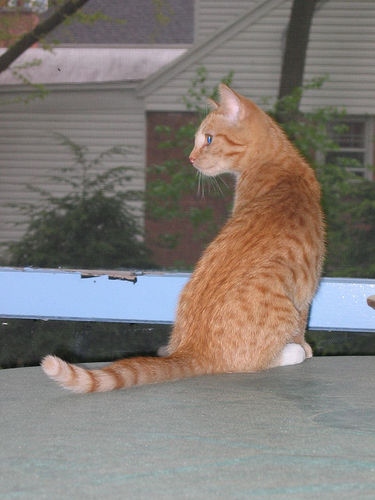

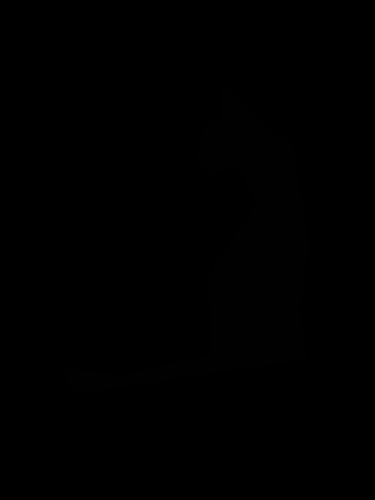

In [30]:
### Main Block: ###

# read image
img_name = 'cat'
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

# read image_mask
poly = scipy.io.loadmat('/content/Part2_GraphCut/cat_poly.mat')['poly']
img_mask = poly2mask(poly[:,1], poly[:,0], (img.shape[0],img.shape[1]))

cv2_imshow(img)
cv2_imshow(img_mask)

Original Image Shape :  (500, 375, 3)
New Image Shape :  (187500, 3)
New Image Shape :  (500, 375)


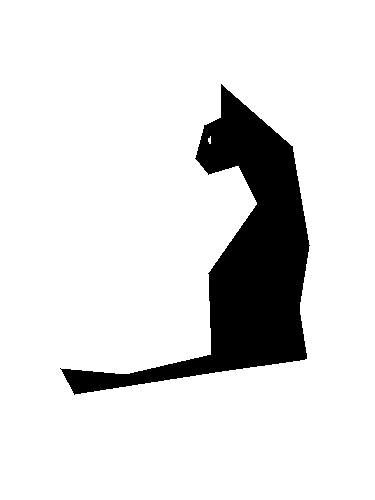

In [31]:
# 1. Fit Gaussian mixture model for foreground regions.

# Generate image (fg_image) with background masked using img_mask
fg_image = mask_for_fg(img, img_mask)
gmm_fg, fg_gmm_labels = gaussian_model(fg_image)

Original Image Shape :  (500, 375, 3)
New Image Shape :  (187500, 3)
New Image Shape :  (500, 375)


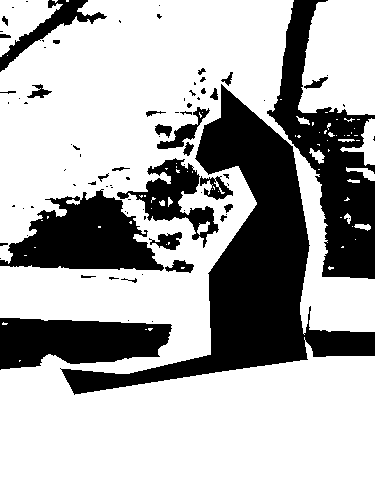

In [32]:
# 2. Fit Gaussian mixture model for background regions.
# Generate image (fg_image) with foreground masked using img_mask
bg_image = mask_for_bg(img, img_mask)
gmm_bg, bg_gmm_labels = gaussian_model(bg_image)


 Orginal Image Shape :  (500, 375, 3)
 Orginal Image Shape after reshapping :  (187500, 3)
log_likelihood_bg SHAPE :   (500, 375)
 Foreground 


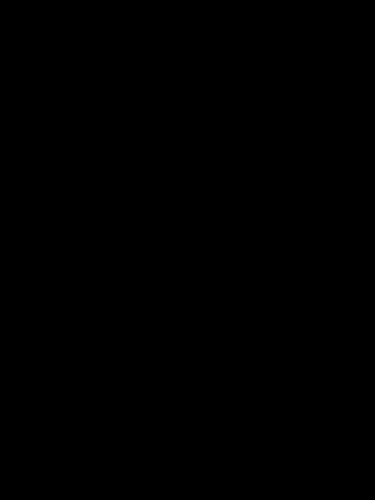

 Background 


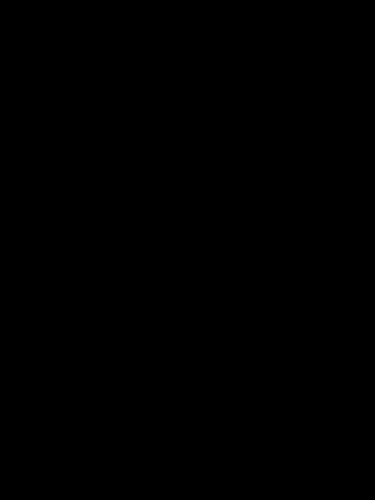

In [33]:
# 3. Compute and visualize the foreground cost and background cost as an image.
# Foreground label cost: -log Pr[Image | foreground model]
# Foreground label cost: -log Pr[Image | background model]

fg,bg = visualize_likelihood_map(gmm_bg, gmm_fg, img)
print(" Foreground ")
cv2_imshow(fg)
print(" Background ")
cv2_imshow(bg)

  cat  


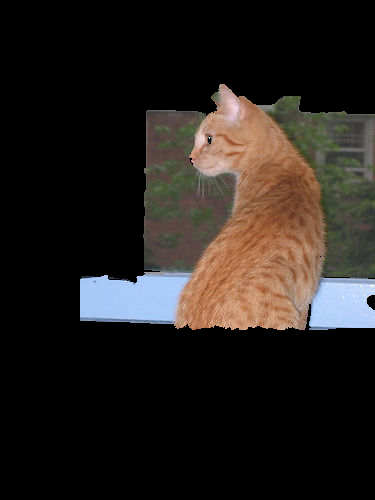

  dog  


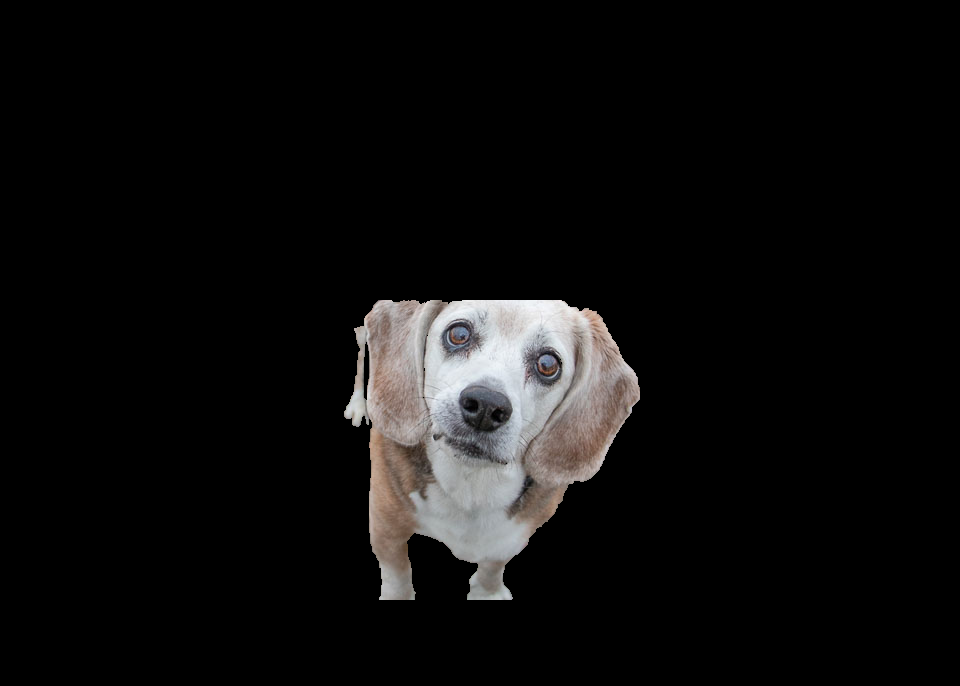

  plane  


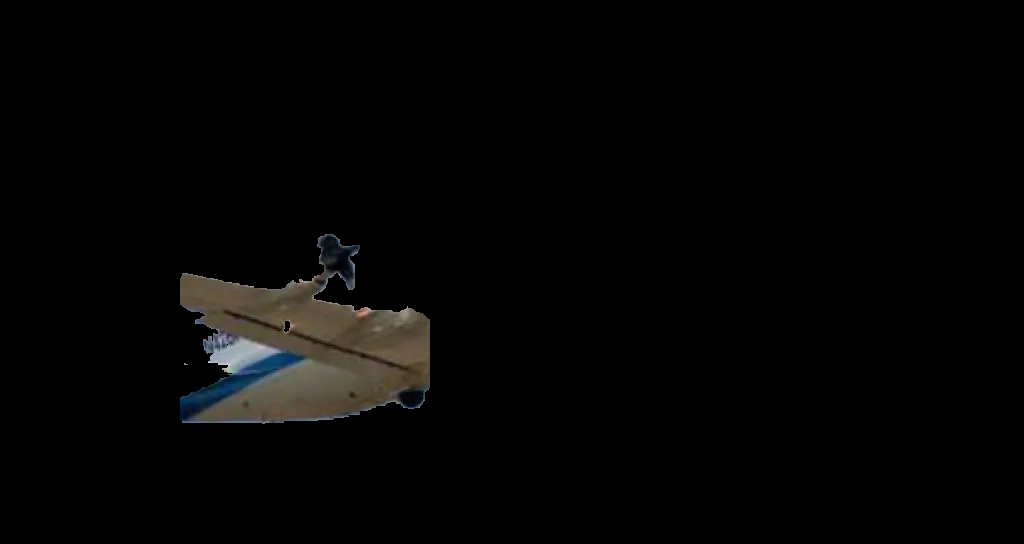

  messi  


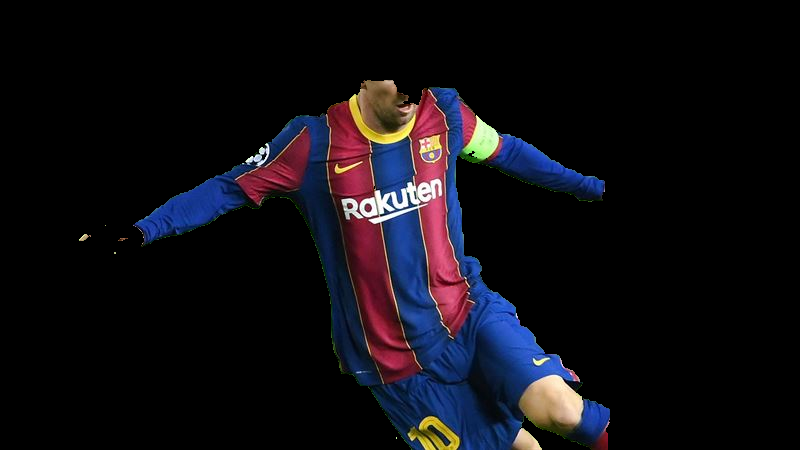

  bird  


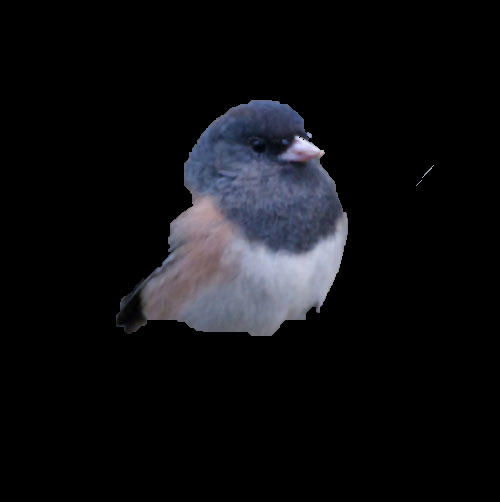

In [34]:
# 4. Run grabcut algorithm.
img_path = '/content/Part2_GraphCut/'
img = cv2.imread(img_path)
bboxes = {'cat':(80,80,320,250), 'dog':(50,300,600,300), 'plane': (180,80,250,800), 'messi':(10,80,600,500), 'bird':(100,100,350,250)}
# bbox = bboxes['dog']
# coord = (250,320,80,80)
for i in bboxes:
  img_path = '/content/Part2_GraphCut/{}.jpg'.format(i)
  img = cv2.imread(img_path)
  # print(img_path)
  print(" " ,i," ")
  run_grabcut(img, bboxes[i],3)


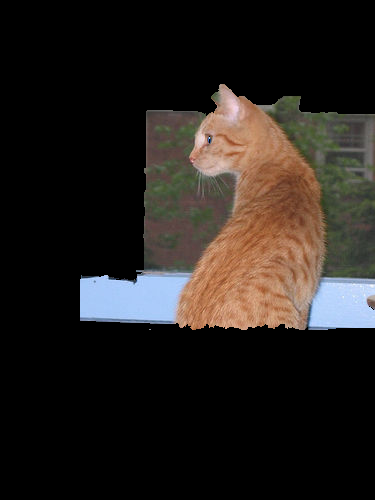

IterCount :  10   . 


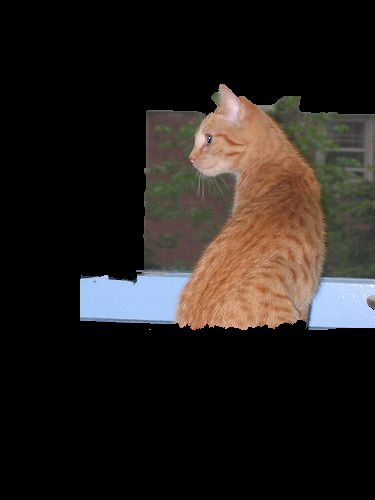

IterCount :  20   . 


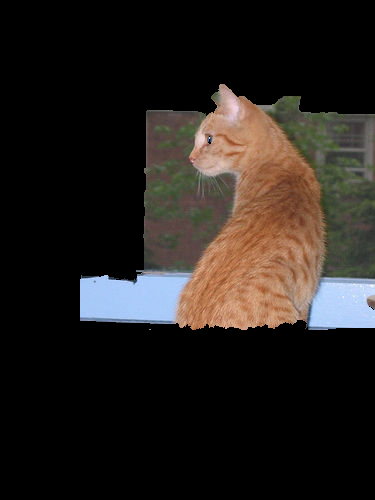

IterCount :  30   . 


In [35]:
t_bbox = bboxes['cat']
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

for i in (10,20,30):
  run_grabcut(img, t_bbox,i)
  print("IterCount : " , i , "  . ")